## Part 1. Login Time Series

### 1.1 EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta

In [95]:
df_lg = pd.read_json("logins.json")

In [96]:
df_lg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [97]:
# get the day_of_week column
def get_day_of_week(ts): 
    num2day = {0:'Mon',
               1:'Tue',
               2:'Wed',
               3:'Thu',
               4:'Fri',
               5:'Sat',
               6:'Sun'}
    return num2day[ts.dayofweek]

df_lg['day_of_week'] = df_lg['login_time'].apply(get_day_of_week)

In [98]:
# get 15-min binned login times without dates from the original datetime64
df_lg['login_time_15min'] = df_lg['login_time'].dt.floor("15min") # time approximation for 15-min binning
df_lg['login_time_15min'] = df_lg['login_time_15min'].dt.time # pd.to_datetime(df['login_time_15min'] , format='%H:%M').dt.time #

In [103]:
# Count logins per 15-min bin on each day of the week
df_lg['count'] = 1 # pad 1s for counting
df_count = df_lg.groupby(['day_of_week','login_time_15min']).sum().reset_index()

In [106]:
# Reformat 'login_time_15min' from datetime.time to string
def strftime_ts(ts):
    return ts.strftime("%H:%M")

df_count['x'] = df_count['login_time_15min'].apply(strftime_ts)

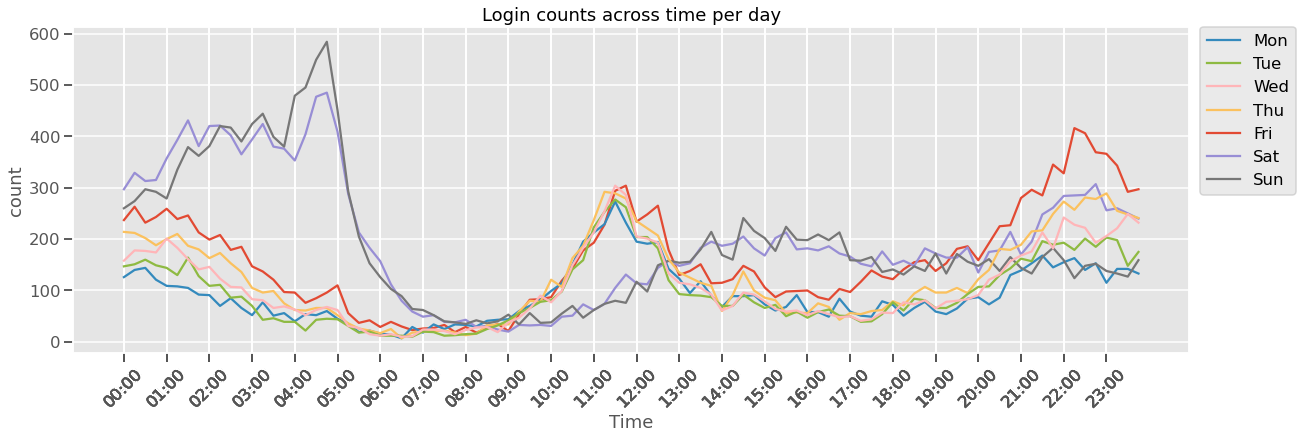

In [116]:
plt.style.use('ggplot')
sns.set_context("talk")
fig, ax = plt.subplots(1,1,figsize=(20,6))
sns.lineplot(x='x', y='count', hue='day_of_week', ax=ax, data=df_count)
ax.set_title('Login counts across time per day')
ax.set_xlabel('Time')
ax.set_xticks(df_count['x'][::4])
ax.set_xticklabels(df_count['x'][::4], rotation=45)
ax.legend()
# get handles and labels
handles, labels = ax.get_legend_handles_labels()
# specify order of items in legend
order = [1, 5, 6, 4, 0, 2, 3]
# update legend
ax.legend([handles[i] for i in order],[labels[i] for i in order], 
           bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.show()

### 1.2 Summary for part 1

By visualizing binned time series of login counts we could reveal characteristic time-varying login patterns across different days of week. 
* Weekdays and weekend showed distinct patterns. 
    * Much greater logins by users were observed between midnight and early morning (00:00~07:00) during the weekend. 
    * During weekdays login count peaked around lunch time and late evening. 

## Part 2. User Retention EDA

### 2.1 Preprocessing

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from dateutil.relativedelta import *
from xgboost import XGBClassifier
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

In [249]:
df_user = pd.read_json("ultimate_data_challenge.json")

In [172]:
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [173]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [174]:
df_user.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [250]:
# Exclude outlies
df_user = df_user[(df_user['trips_in_first_30_days']<125) & (df_user['avg_dist']<100)]

In [251]:
# Count missing data in each column
df_user.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8120
avg_surge                    0
last_trip_date               0
phone                      395
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       200
dtype: int64

In [252]:
# Reformat string-typed datetime to datetime64 
def objectToDatetime(obj):
    return pd.Timestamp(obj)
df_user['signup_date'] = df_user['signup_date'].apply(objectToDatetime)
df_user['last_trip_date'] = df_user['last_trip_date'].apply(objectToDatetime)

In [253]:
# Determine user retention (users are considered to be retained if they were “active” (i.e. took a trip) in the preceding 30 days)
def retention(signup_date, last_trip_date):
    plus_6m = relativedelta(months=+6)
    minus_30d = timedelta(days=-30)
    ref_date = signup_date + relativedelta(months=+6) + minus_30d
    return last_trip_date > ref_date

df_user['retention'] = df_user.apply(lambda x: retention(signup_date=x['signup_date'], last_trip_date=x['last_trip_date']), axis=1) # must provide 'axis=1' argument to apply function to each row

In [180]:
df_user.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


### 2.2 EDA

#### 2.2.1 EDA functions

In [225]:
def count_bar_for_discretes(df, x_col, y_col, std_range=0):
    if std_range != 0:
        mean = np.mean(df[x_col]) 
        stdev = np.std(df[x_col])
        df = df[df[x_col] < mean + (std_range * stdev)]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    sns.countplot(x=x_col, hue=y_col, data=df, ax=ax[0])
    ax[0].set_title('countplot by ' + x_col, fontsize=16)
    sns.barplot(x=x_col, y=y_col, data=df, ax=ax[1])
    ax[1].set_title(y_col + ' rate by ' + x_col, fontsize=16)
    plt.tight_layout()
    plt.show()

In [224]:
# Distribution of the retention vs no-retention
def histogram_density_groupby_mean(df, x_col, y_col, bin_0=30, bin_1=20, std_range=0):
    if std_range != 0:
        mean = np.mean(df[x_col]) 
        stdev = np.std(df[x_col])
        df = df[df[x_col] < mean + (std_range * stdev)]
    
    grouped = df[[x_col, y_col]].groupby(x_col).mean().reset_index()
    hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    sns.histplot(data=df[df[y_col] == 0][x_col], ax=ax[0], stat='density', kde=True, 
                 bins=np.histogram_bin_edges(df[df[y_col] == 0][x_col], bins=bin_0), color='blue', label='y_0')
    sns.histplot(data=df[df[y_col] == 1][x_col], ax=ax[0], stat='density', kde=True, 
                 bins=np.histogram_bin_edges(df[df[y_col] == 1][x_col], bins=bin_1), color='orange', label='y_1')
    ax[0].set_title('Density plot by ' + x_col, fontsize=16)
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels)
    
    ax[1].plot(grouped[x_col], grouped[y_col], '.-')
    ax[1].set_title('mean retention rate vs. ' + x_col, fontsize=16)
    ax[1].set_xlabel(x_col)
    ax[1].set_ylabel(y_col)
    ax[1].grid(True)
    plt.show()

#### 2.2.2 Retention rate by phone type (discrete)

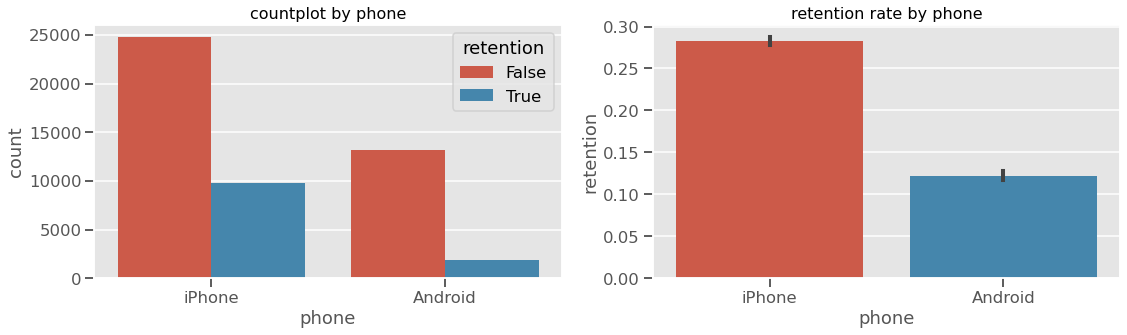

In [226]:
count_bar_for_discretes(df_user, 'phone', 'retention', std_range=0)

iPhone users showed greater service usage and retention rate compared to Android users. This is an opportunity to check the Android service (e.g. Is there any discrepancy between apps on iPhone vs. Android in terms of the application and/or the amount of advertisement?)

#### 2.2.3 Retention rate by city (discrete)

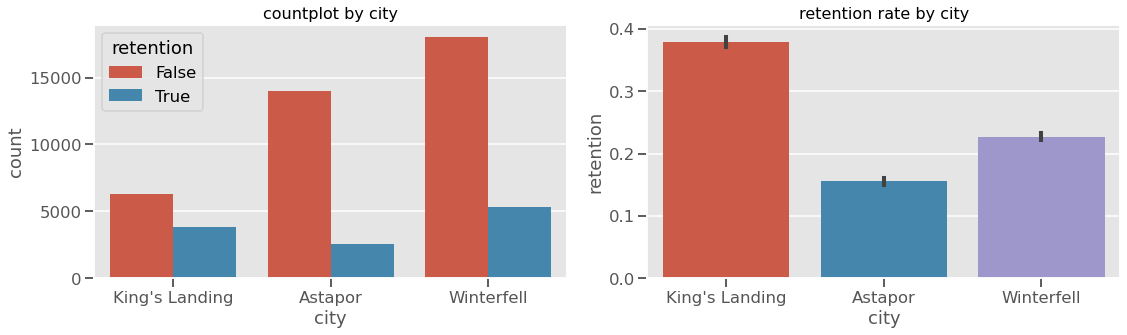

In [312]:
count_bar_for_discretes(df_user, 'city', 'retention', std_range=0)

The retention rate in King's Landing appeared to be higher than the other cities. This suggests that an increased supply in King's Landing could be profitable, assuming that the city has more demands. 

#### 2.2.4 Retention rate by ultimate black usage (discrete)

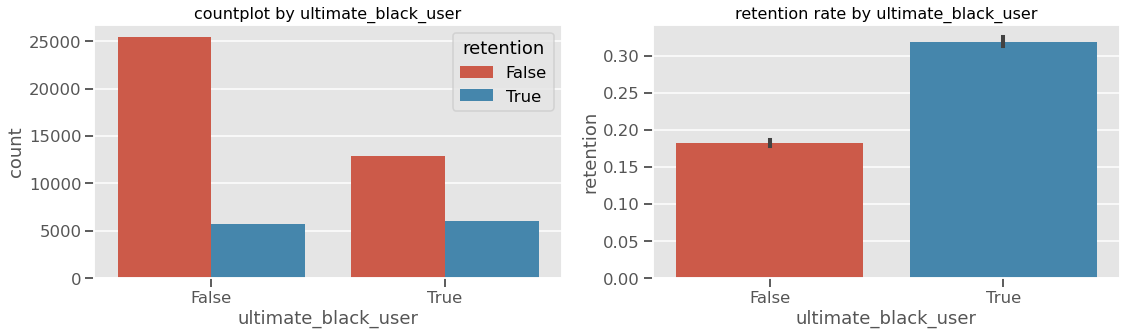

In [228]:
count_bar_for_discretes(df_user, 'ultimate_black_user', 'retention', std_range=0)

Ultimate black (premium service) useres were more likely to be retained. 

#### 2.2.5 Retention rate by trips in first 30 days (Countinuous)

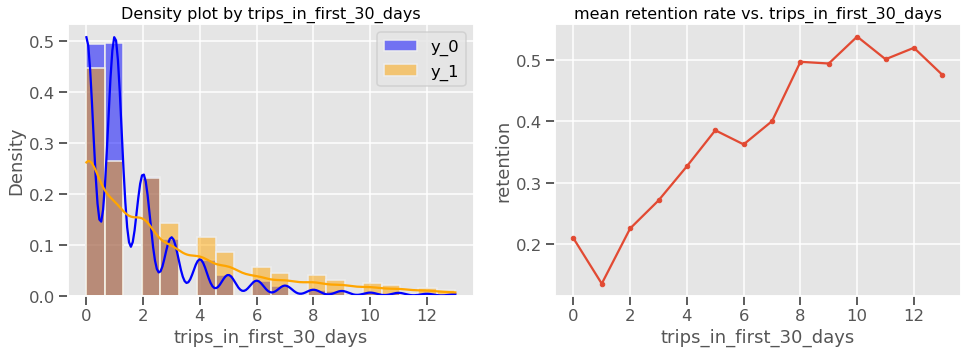

In [229]:
histogram_density_groupby_mean(df_user, 'trips_in_first_30_days', 'retention', bin_0=20, bin_1=20, std_range=3)

Users that took more trips within first 30 days were more likely to be retained. 

#### 2.2.6 Retention rate by average surge (Countinuous)

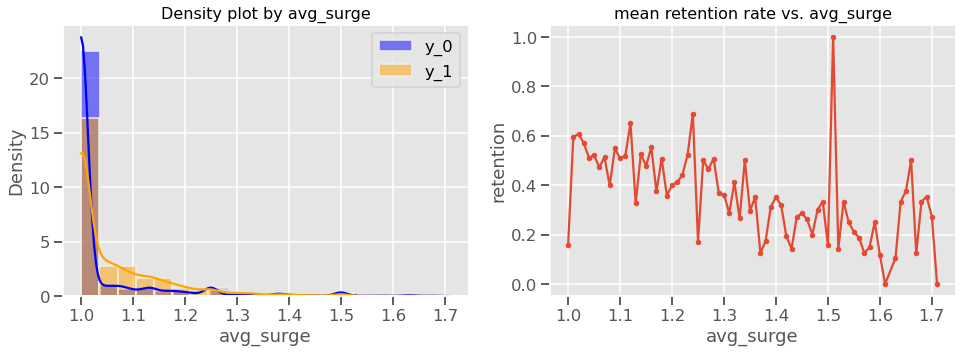

In [231]:
histogram_density_groupby_mean(df_user, 'avg_surge', 'retention', bin_0=20, bin_1=20, std_range=3)

There is no clear relationship between average surge and retention rate, perhaps a weak negative correlation.  

#### 2.2.7 Retention rate by average rating by driver (Countinuous)

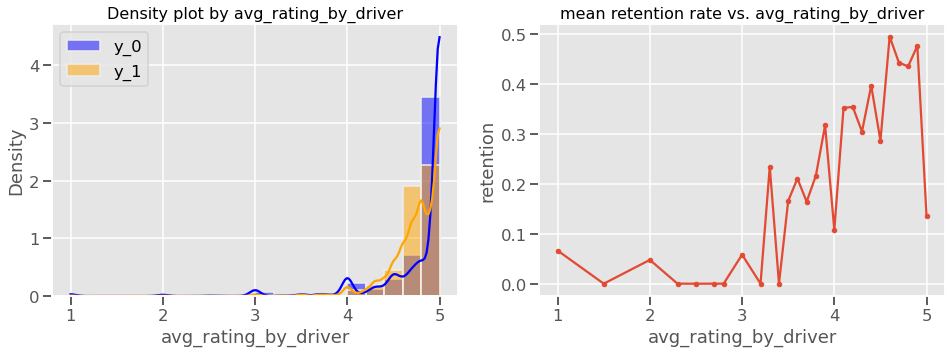

In [237]:
histogram_density_groupby_mean(df_user, 'avg_rating_by_driver', 'retention', bin_0=20, bin_1=20, std_range=3)

There is no clear relationship between average rating by driver and retention rate, perhaps a weak positive correlation, i.e., users higher rated by drivers are more likely to be retained.  

Note that we did not oberve any systematic relationship in average_rating_of/by_driver, surge_pct, weekday_pct, avg_dist variable s with user retention. Thus, we omitted plots of those variables for simplicity. 

### 2.3 User Retention Predictive Modeling

#### 2.3.1 Encode categorical variables

In [254]:
# transfrom categorical and boolean variables to integers
df_user_dm = pd.get_dummies(df_user) # one-hot encoding of categorical variables
df_user_dm['ultimate_black_user'] = df_user['ultimate_black_user'].astype('int')
df_user_dm['retention'] = df_user['retention'].astype('int')
df_user_dm.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


#### 2.3.2 Split dataset into train and test sets

In [255]:
# Split dataset into train and test sets
y = df_user_dm['retention']
X = df_user_dm.drop(axis=1, columns=['signup_date', 'last_trip_date', 'retention']) # do not drop either phone_Android or phone_iPhone as they are yet other class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### 2.3.3 Impute missing values

In [256]:
# Try IterativeImputer to fill missing values by modeling each feature with missing values as a function of other features
imputer = IterativeImputer()
X_train.loc[:,X_train.columns] = imputer.fit_transform(X_train)
X_test.loc[:,X_test.columns] = imputer.transform(X_test)
X_train.info() # note that all missing values are imputed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37497 entries, 41030 to 1209
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  37497 non-null  float64
 1   avg_rating_of_driver    37497 non-null  float64
 2   avg_surge               37497 non-null  float64
 3   surge_pct               37497 non-null  float64
 4   ultimate_black_user     37497 non-null  float64
 5   weekday_pct             37497 non-null  float64
 6   avg_dist                37497 non-null  float64
 7   avg_rating_by_driver    37497 non-null  float64
 8   city_Astapor            37497 non-null  float64
 9   city_King's Landing     37497 non-null  float64
 10  city_Winterfell         37497 non-null  float64
 11  phone_Android           37497 non-null  float64
 12  phone_iPhone            37497 non-null  float64
dtypes: float64(13)
memory usage: 4.0 MB


#### 2.3.4 Hyperparameter optimization with 5-fold cross validation

In [262]:
# https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/
# get a list of models to evaluate
def get_XGBoost_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees: 
        models[str(n)] = XGBClassifier(n_estimators=n)
    return models

In [261]:
def get_RF_models():
    models = dict()
    trees = [10, 50, 100, 500, 1000]
    for n in trees: 
        models[str(n)] = RandomForestClassifier(n_estimators=n)
    return models

In [259]:
# evaluate a give model using cross-validation
# Accuracy = (TP+TN)/(TP+FP+FN+TN)
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=45)
	scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

#### 2.3.5 Optimize, train and evaluate Random Forest classifier 

#### 2.3.5.1 Hyperparameter optimization for Random Forest classifier with grid search

10, mean: 0.772, std: 0.003
50, mean: 0.776, std: 0.005
100, mean: 0.777, std: 0.004
500, mean: 0.777, std: 0.005
1000, mean: 0.777, std: 0.004


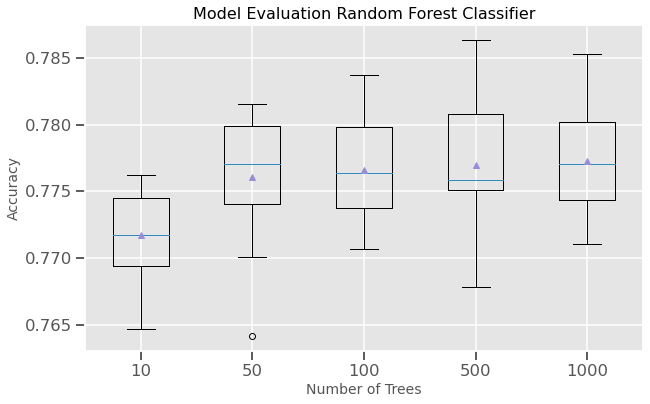

In [269]:
# get XGBoost models to evaluate
rf_models = get_RF_models()

# evalutate the models and store results
rf_results, rf_names = list(), list()
for name, model in rf_models.items(): 
    rf_scores = evaluate_model(model)
    rf_results.append(rf_scores)
    rf_names.append(name)
    print(name + ', mean: {0:.3f}, std: {1:.3f}'.format(np.mean(rf_scores), np.std(rf_scores)))
    
# plot model performance for comparison
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.boxplot(rf_results, labels=rf_names, showmeans=True)
ax.set_title("Model Evaluation Random Forest Classifier", fontsize=16)
ax.set_xlabel("Number of Trees", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
plt.show()

#### 2.3.5.2 Fit, predict, evaluate Random Forest classifier

In [271]:
# fit model no training data
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)
print(rf_model)
# make predictions for test data
y_pred_rf = rf_model.predict(X_test)
rf_predictions = [round(value) for value in y_pred_rf]

RandomForestClassifier(n_estimators=500)


In [272]:
# classification report
print(classification_report(y_test, y_pred_rf))
# confusion matrix
print(confusion_matrix(y_test, y_pred_rf))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      9577
           1       0.55      0.42      0.48      2923

    accuracy                           0.78     12500
   macro avg       0.69      0.66      0.67     12500
weighted avg       0.77      0.78      0.77     12500

[[8573 1004]
 [1696 1227]]


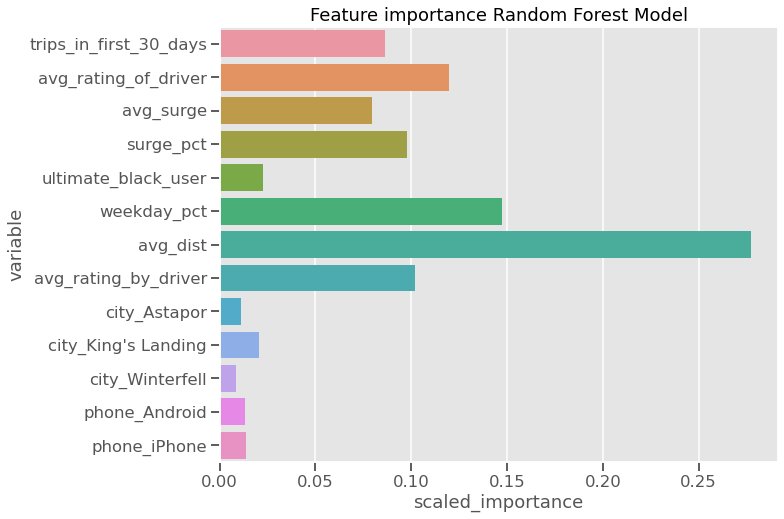

In [289]:
importance = rf_model.feature_importances_

df_rf_importance = pd.DataFrame({'variable': X_train.columns, 'scaled_importance':importance})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='scaled_importance', y='variable', data=df_rf_importance, ax=ax)
ax.set_title('Feature importance Random Forest Model')
plt.show()

#### 2.3.6 Optimize, train and evaluate XGBoost classifier 

#### 2.3.6.1 Hyperparameter optimization for XGBoost classifier with grid search

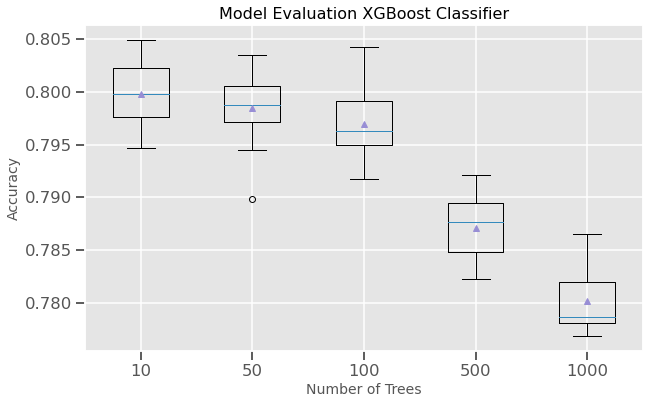

In [292]:
# get XGBoost models to evaluate
xgb_models = get_XGBoost_models()

# evalutate the models and store results
xgb_results, xgb_names = list(), list()
for name, model in xgb_models.items(): 
    xgb_scores = evaluate_model(model)
    xgb_results.append(xgb_scores)
    xgb_names.append(name)
    print(name + ', mean: {0:.3f}, std: {1:.3f}'.format(np.mean(xgb_scores), np.std(xgb_scores)))
    
# plot model performance for comparison
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.boxplot(xgb_results, labels=xgb_names, showmeans=True)
ax.set_title("Model Evaluation XGBoost Classifier", fontsize=16)
ax.set_xlabel("Number of Trees", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
plt.show()

#### 2.3.6.2 Fit, predict, evaluate XGBoost classifier

In [293]:
# fit model no training data
xgb_model = XGBClassifier(n_estimators=10, use_label_encoder=False)
xgb_model.fit(X_train, y_train)
print(xgb_model)
# make predictions for test data
y_pred_xgb = xgb_model.predict(X_test)
xgb_predictions = [round(value) for value in y_pred_xgb]

[16:32:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [296]:
# classification report
print(classification_report(y_test, y_pred_xgb))
# confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_xgb).ravel()

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      9577
           1       0.64      0.38      0.47      2923

    accuracy                           0.80     12500
   macro avg       0.73      0.66      0.68     12500
weighted avg       0.79      0.80      0.78     12500

[[8948  629]
 [1823 1100]]


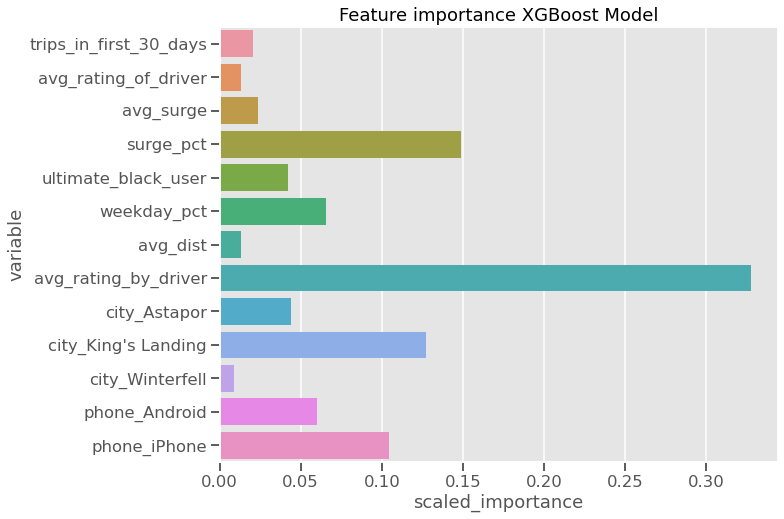

In [297]:
importance = xgb_model.feature_importances_

df_xgb_importance = pd.DataFrame({'variable': X_train.columns, 'scaled_importance':importance})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='scaled_importance', y='variable', data=df_xgb_importance, ax=ax)
ax.set_title('Feature importance XGBoost Model')
plt.show()

#### 2.3.7 Model comparison

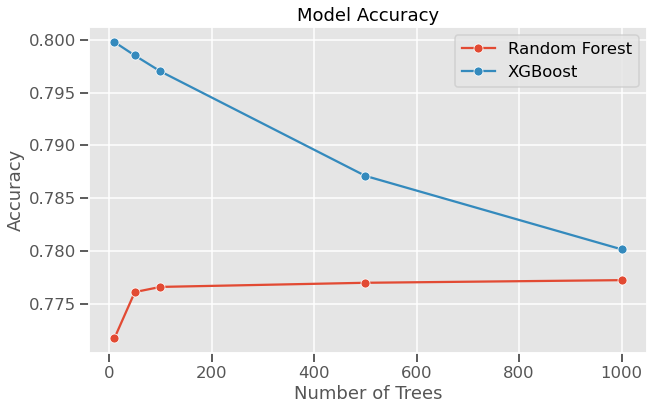

In [309]:
df_model_compare = pd.DataFrame({'trees':[10, 50, 100, 500, 1000], 
                                 'rf_accuracy':[np.mean(rf_rez) for rf_rez in rf_results],
                                 'xgb_accuracy':[np.mean(xgb_rez) for xgb_rez in xgb_results]
                                })

fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.lineplot(data=df_model_compare, x='trees', y='rf_accuracy', legend=True, label='Random Forest', marker='o', ax=ax) 
sns.lineplot(data=df_model_compare, x='trees', y='xgb_accuracy', legend=True, label='XGBoost', marker='o', ax=ax) 
ax.set_title('Model Accuracy')
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Accuracy')
plt.show()

#### 2.4 Summary for Part 2 (user retention)

We analyzed user profile and behavioral data, and built a model that predicts whether a user would stay active about six months after signup.   
Our EDA led to some intriguing observations: 
1. iPhone users showed greater logins and were more likely to stay active than android users.
2. The retention rate in King's Landing appeared to be highest, this is despite the fact that the city's number of logins was lowest. 
3. Users that were more activity duing the first month were more likely to be activity 6 months later. 
4. Users with higher ratings by drivers were more likely to be retained. 
These findings suggest that the dataset could be informative to build predictive models based upon. 

We built two tree-based classifiers one using bagging (Random Forest) and the other using gradient boosting (XGBoost), which predicted users to be retained or not after 6 months. 
1. The two models showed comparable performance. 
2. The XGBoost model showed a relatively high false negative rate (0.62 vs 0.58).
3. The Random forest model showed a relatively high false positive rate (0.1 vs 0.06). 